# Multidimensional Pattern identification with SAX
## Building Benchmarking


This script performs pattern identification over the {time, site} cuboid, which shows an inter-building analytical frame, typically relevant for cross building benchmarking.

The data is first normalized then transformed using SAX over normalized daily sequences. Motifs are identified across buildings, and a final clustering phase is executed over the reduced counts of sequences. 

Results are presented visually allowing interpretable analytics.

In [1]:
# Import modules
import pandas as pd
import numpy as np
import time
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from collections import Counter
# Plotting modules
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcdefaults()
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)
import plotly.io as pio
# Importing utility script
import utils as ut

# Version
version = "v1.0"

# Path definition
path_data = "..\\data\\cube\\"
path_fig_out = "..\\figures\\building_bench\\"

## Read

In [2]:
# Read Cuboid
meter = "electricity"
df = pd.read_csv(path_data + "cuboid_A_"+meter+".csv", index_col="timestamp")
df.dropna(axis=1, how='all', inplace=True)

# Format index to datetime object
df.index = pd.to_datetime(df.index, format='%Y-%m-%d %H:%M:%S')
df.head()

,Bear_assembly_Angel,Bear_assembly_Beatrice,Bear_assembly_Danial,Bear_assembly_Diana,Bear_assembly_Genia,Bear_assembly_Harry,Bear_assembly_Jose,Bear_assembly_Roxy,Bear_assembly_Ruby,Bear_education_Alfredo,...,Wolf_office_Emanuel,Wolf_office_Haydee,Wolf_office_Joana,Wolf_office_Nadia,Wolf_office_Rochelle,Wolf_public_Norma,Wolf_retail_Harriett,Wolf_retail_Marcella,Wolf_retail_Toshia,Wolf_science_Alfreda
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,225.750,9.562500,NaN,NaN,183.125,NaN,149.75,9.8125,51.6250,0.100647,...,13.492188,5.363281,14.796875,50.250,8.843750,71.6875,22.093750,9.640625,17.937500,87.2500
2016-01-01 01:00:00,225.750,9.562500,NaN,NaN,183.125,NaN,149.75,9.8125,51.6250,0.100647,...,13.492188,5.363281,14.796875,50.250,8.843750,71.6875,22.093750,9.640625,17.937500,87.2500
2016-01-01 02:00:00,225.750,9.562500,NaN,NaN,183.125,NaN,149.75,9.8125,51.6250,0.100647,...,13.492188,5.363281,14.796875,50.250,8.843750,71.6875,22.093750,9.640625,17.937500,87.2500
2016-01-01 03:00:00,222.375,9.812500,NaN,NaN,185.250,NaN,152.25,9.8750,51.6250,0.104370,...,13.460938,5.886719,14.960938,50.250,8.742188,71.2500,21.828125,9.539062,17.875000,87.0000
2016-01-01 04:00:00,227.375,9.546875,NaN,NaN,185.500,NaN,151.25,9.9375,51.3125,0.106262,...,13.398438,5.835938,15.031250,50.125,8.679688,71.6875,21.687500,9.492188,17.609375,86.9375


# Pre-Mining
## Motifs identification

In [3]:
# SAX Parameters
day_number_of_pieces = 4
alphabet_size = 3
scaler_function = StandardScaler()

# Normalize per attribute robust to Nans
df_normalized = ut.scale_df_columns_NanRobust(df, df.columns, scaler=scaler_function)

# SAX transformation
sax_dict, counts, sax_data = ut.SAX_mining(df_normalized, W=day_number_of_pieces, A=alphabet_size)

In [5]:
# Identifying sequence counts per building
df_count = ut.sax_count_reformat(sax_dict)
df_count.fillna(0, inplace=True)

# Plotting per building sequence counts as heatmap
fig = ut.SAXcount_hm_wdendro(df_count)
fig.show()
fig.write_image(path_fig_out+"SAXcounts_"+meter+"_"+version+".png", width=1200, height=800)
fig.write_html(path_fig_out+"SAXcounts_"+meter+"_"+version+".html")

# Mining
## Cross-building clustering
We proceed to perform cross-site clustering based on motif similarities between them.

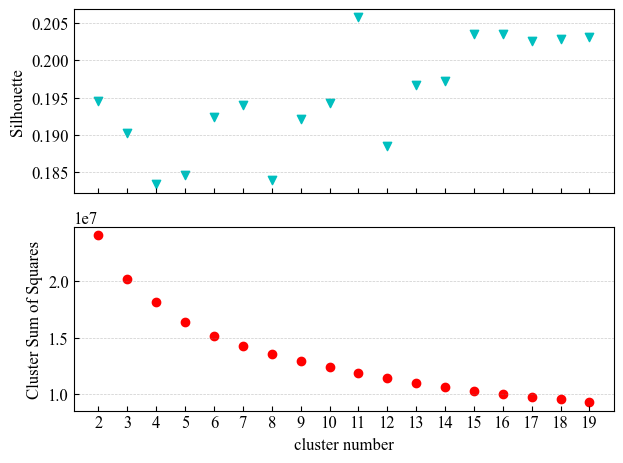

In [6]:
## Clustering identified motifs

# Filter discords from established threshold
motif_threshold_number = 5
df_count_motifs = df_count[df_count > motif_threshold_number]
df_count_motifs.fillna(0, inplace=True)

# Identify optimal cluster number
wcss, sil = ut.elbow_method(df_count_motifs.transpose(), n_cluster_max=20)

# Plots
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.sans-serif'] = ['Times New Roman']
fig = ut.similarity_index_plot(wcss, sil)
fig.savefig(path_fig_out+"CrossBlg_"+meter+"_cluster_SimilarityIndex_"+version+".jpg", dpi=300, bbox_inches='tight')

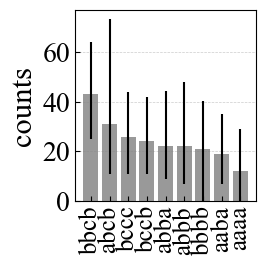

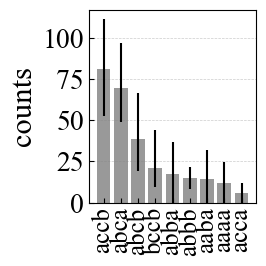

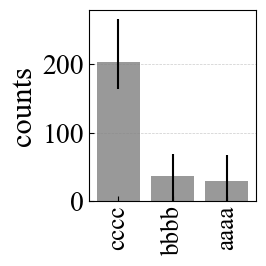

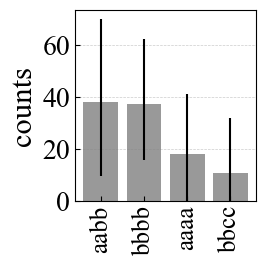

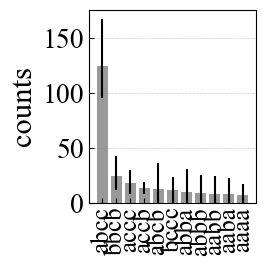

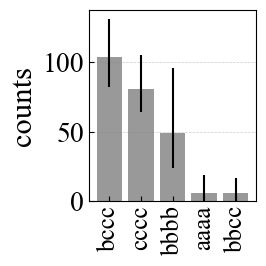

In [12]:
# Cluster identified motifs
nb_clusters_opt = 6
kmeans = KMeans(n_clusters=nb_clusters_opt, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans_pred_y = kmeans.fit_predict(df_count_motifs.transpose())

# Identify buildings & motifs per cluster
blg_clus, motifs, count_clustmotifs = dict(), dict(), dict()
for clus in range(nb_clusters_opt):
    # Identifying buildings within the cluster
    blg_clus[clus] = df_count_motifs.transpose()[kmeans_pred_y == clus].index.values
    # Extracting motifs within the cluster without empty columns (only zeros)
    dfc = df_count_motifs[blg_clus[clus]].replace(0, np.nan)
    dfc = dfc.dropna(how='all', axis=0)
    dfc = dfc.replace(np.nan, 0)
    motifs[clus] = dfc.index.values
    # Extracting motifs counts within cluster
    count_clustmotifs[clus] = df_count_motifs[blg_clus[clus]].transpose()[motifs[clus]]
    # Extract motifs median information from counts
    medians = count_clustmotifs[clus].describe().loc['50%']
    # Filter only motif-medians above threshold
    count_clustmotifs[clus] = count_clustmotifs[clus][medians[medians > motif_threshold_number].index.values]

# Plot counts per cluster as bar plots with whisker margins
plt.rcParams.update({'font.size': 18})
for clus in count_clustmotifs:
    fig = ut.cluster_counter_plot(count_clustmotifs[clus], title="cluster " + str(clus) +" (N="+str(len(blg_clus[clus]))+")")
    fig.savefig(path_fig_out+"SAXclust_"+meter+"_clust"+str(clus)+"_"+version+".jpg", dpi=300, bbox_inches='tight')